<a href="https://colab.research.google.com/github/O-NS23/Hospital-Readmission-Prediction-Impact-of-Medication-on-Lifestyle-Disease-Patients/blob/main/MedicalDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [2]:
# 1. LOAD DATASETS
train_df = pd.read_csv("/content/train_dataset.csv")
test_df = pd.read_csv("/content/test_dataset.csv")

In [3]:
# 2. DEFINE THE PROCESSING LOGIC
def process_dataframe(df):
    # A. Standardize Missing Values
    df = df.replace('?', np.nan)

    # B. Smart Imputation (Filling Missing Values)
    # Fill Race with Mode
    if 'race' in df.columns:
        df['race'] = df['race'].fillna('Other')

    # Fill Medical Specialty (Grouped by Age as you liked!)
    if 'medical_specialty' in df.columns:
        df['medical_specialty'] = df.groupby('age')['medical_specialty'].transform(
            lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Missing')
        )
        df['medical_specialty'] = df['medical_specialty'].fillna('Missing')

    # Fill Diagnoses
    for col in ['diag_1', 'diag_2', 'diag_3', 'diag_4', 'diag_5']:
        if col in df.columns:
            df[col] = df[col].fillna('Missing')

    # C. Drop Empty/Useless Columns (Weight, X1, X2)
    # We drop these NOW because they are empty. We drop IDs LATER.
    cols_to_drop = ['weight', 'X1', 'X2']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

    # D. Feature Engineering (Math)
    # Age Map: Convert [10-20) to 15
    age_map = {'[0-10)':5, '[10-20)':15, '[20-30)':25, '[30-40)':35,
               '[40-50)':45, '[50-60)':55, '[60-70)':65, '[70-80)':75,
               '[80-90)':85, '[90-100)':95}
    if df['age'].dtype == 'object':
        df['age'] = df['age'].map(age_map)

    # Total Visits (Crucial Feature)
    # Fill with 0 first to safely add
    for c in ['number_inpatient', 'number_outpatient', 'number_emergency']:
        df[c] = df[c].fillna(0)
    df['total_visits'] = df['number_inpatient'] + df['number_outpatient'] + df['number_emergency']

    # Binary Encodings
    if 'change' in df.columns:
        df['change'] = df['change'].apply(lambda x: 1 if x == 'Ch' else 0)
    if 'diabetesMed' in df.columns:
        df['diabetesMed'] = df['diabetesMed'].apply(lambda x: 1 if x == 'Yes' else 0)

    return df

# Apply to both
print("Processing Train and Test data...")
train_df = process_dataframe(train_df)
test_df = process_dataframe(test_df)

# Drop duplicates ONLY from Train
train_df = train_df.drop_duplicates()

Processing Train and Test data...


In [4]:
# 3. COMBINE FOR UNIFIED ENCODING
train_df['source'] = 'train'
test_df['source'] = 'test'
all_data = pd.concat([train_df, test_df], ignore_index=True)

In [5]:
# 4. DROP IDENTIFIERS
# Now we remove the IDs as we prepare for the AI model
ids_to_drop = ['encounter_id', 'patient_id', 'index']
all_data = all_data.drop(columns=[c for c in ids_to_drop if c in all_data.columns])

In [6]:
# 5. LABEL ENCODE (Text -> Numbers)
cat_cols = all_data.select_dtypes(include=['object']).columns
cat_cols = [c for c in cat_cols if c != 'source'] # Don't encode 'source'

print(f"Encoding columns: {list(cat_cols)}")
for col in cat_cols:
    le = LabelEncoder()
    all_data[col] = le.fit_transform(all_data[col].astype(str))

Encoding columns: ['race', 'gender', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'diag_4', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25']


In [7]:
# 6. SPLIT BACK & SCALE
train_final = all_data[all_data['source'] == 'train'].drop(columns=['source'])
test_final = all_data[all_data['source'] == 'test'].drop(columns=['source'])

# Separate Target
target_col = 'readmitted'
X_train = train_final.drop(columns=[target_col])
y_train = train_final[target_col].astype(int)
X_test = test_final.drop(columns=[target_col], errors='ignore')

# MinMax Scale (0 to 1)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [13]:
# RESULTS
print("\n--- Phase 2 Complete ---")
print(f"Train Features Shape: {X_train_scaled.shape}")
print(f"Test Features Shape: {X_test_scaled.shape}")
print(f"Target Shape: {y_train.shape}")



--- Phase 2 Complete ---
Train Features Shape: (48911, 43)
Test Features Shape: (16647, 43)
Target Shape: (48911,)


In [14]:
X_train_scaled.head()

,race,gender,age,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,X19,X20,X21,X22,X23,X24,X25,change,diabetesMed,total_visits
0,0.75,0.5,0.888889,0.230769,0.107692,0.296875,0.166667,0.1000,0.025641,0.015873,...,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.088235
1,0.50,0.5,0.666667,0.153846,0.107692,0.257812,0.166667,0.1375,0.000000,0.000000,...,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.50,0.0,0.555556,0.384615,0.276923,0.382812,0.333333,0.2875,0.000000,0.000000,...,0.0,0.000000,0.333333,0.0,0.0,0.0,0.0,1.0,1.0,0.073529
3,0.00,0.0,0.777778,0.307692,0.261538,0.484375,0.000000,0.1625,0.000000,0.000000,...,0.0,0.000000,0.333333,0.0,0.0,0.0,0.0,1.0,1.0,0.000000
4,0.50,0.5,0.777778,0.615385,0.661538,0.125000,0.166667,0.1250,0.000000,0.000000,...,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [12]:
X_test_scaled.head()

,race,gender,age,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,X19,X20,X21,X22,X23,X24,X25,change,diabetesMed,total_visits
0,0.5,0.0,0.777778,0.153846,0.261538,0.343750,0.500000,0.1125,0.000000,0.0,...,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.014706
1,0.5,0.5,0.666667,0.076923,0.261538,0.070312,0.166667,0.1875,0.025641,0.0,...,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.014706
2,0.0,0.5,0.777778,0.769231,0.261538,0.312500,0.166667,0.1750,0.000000,0.0,...,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.014706
3,0.5,0.0,0.777778,0.000000,0.261538,0.546875,0.333333,0.1250,0.000000,0.0,...,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.555556,0.461538,0.261538,0.453125,0.333333,0.2125,0.000000,0.0,...,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,1.0,1.0,0.000000


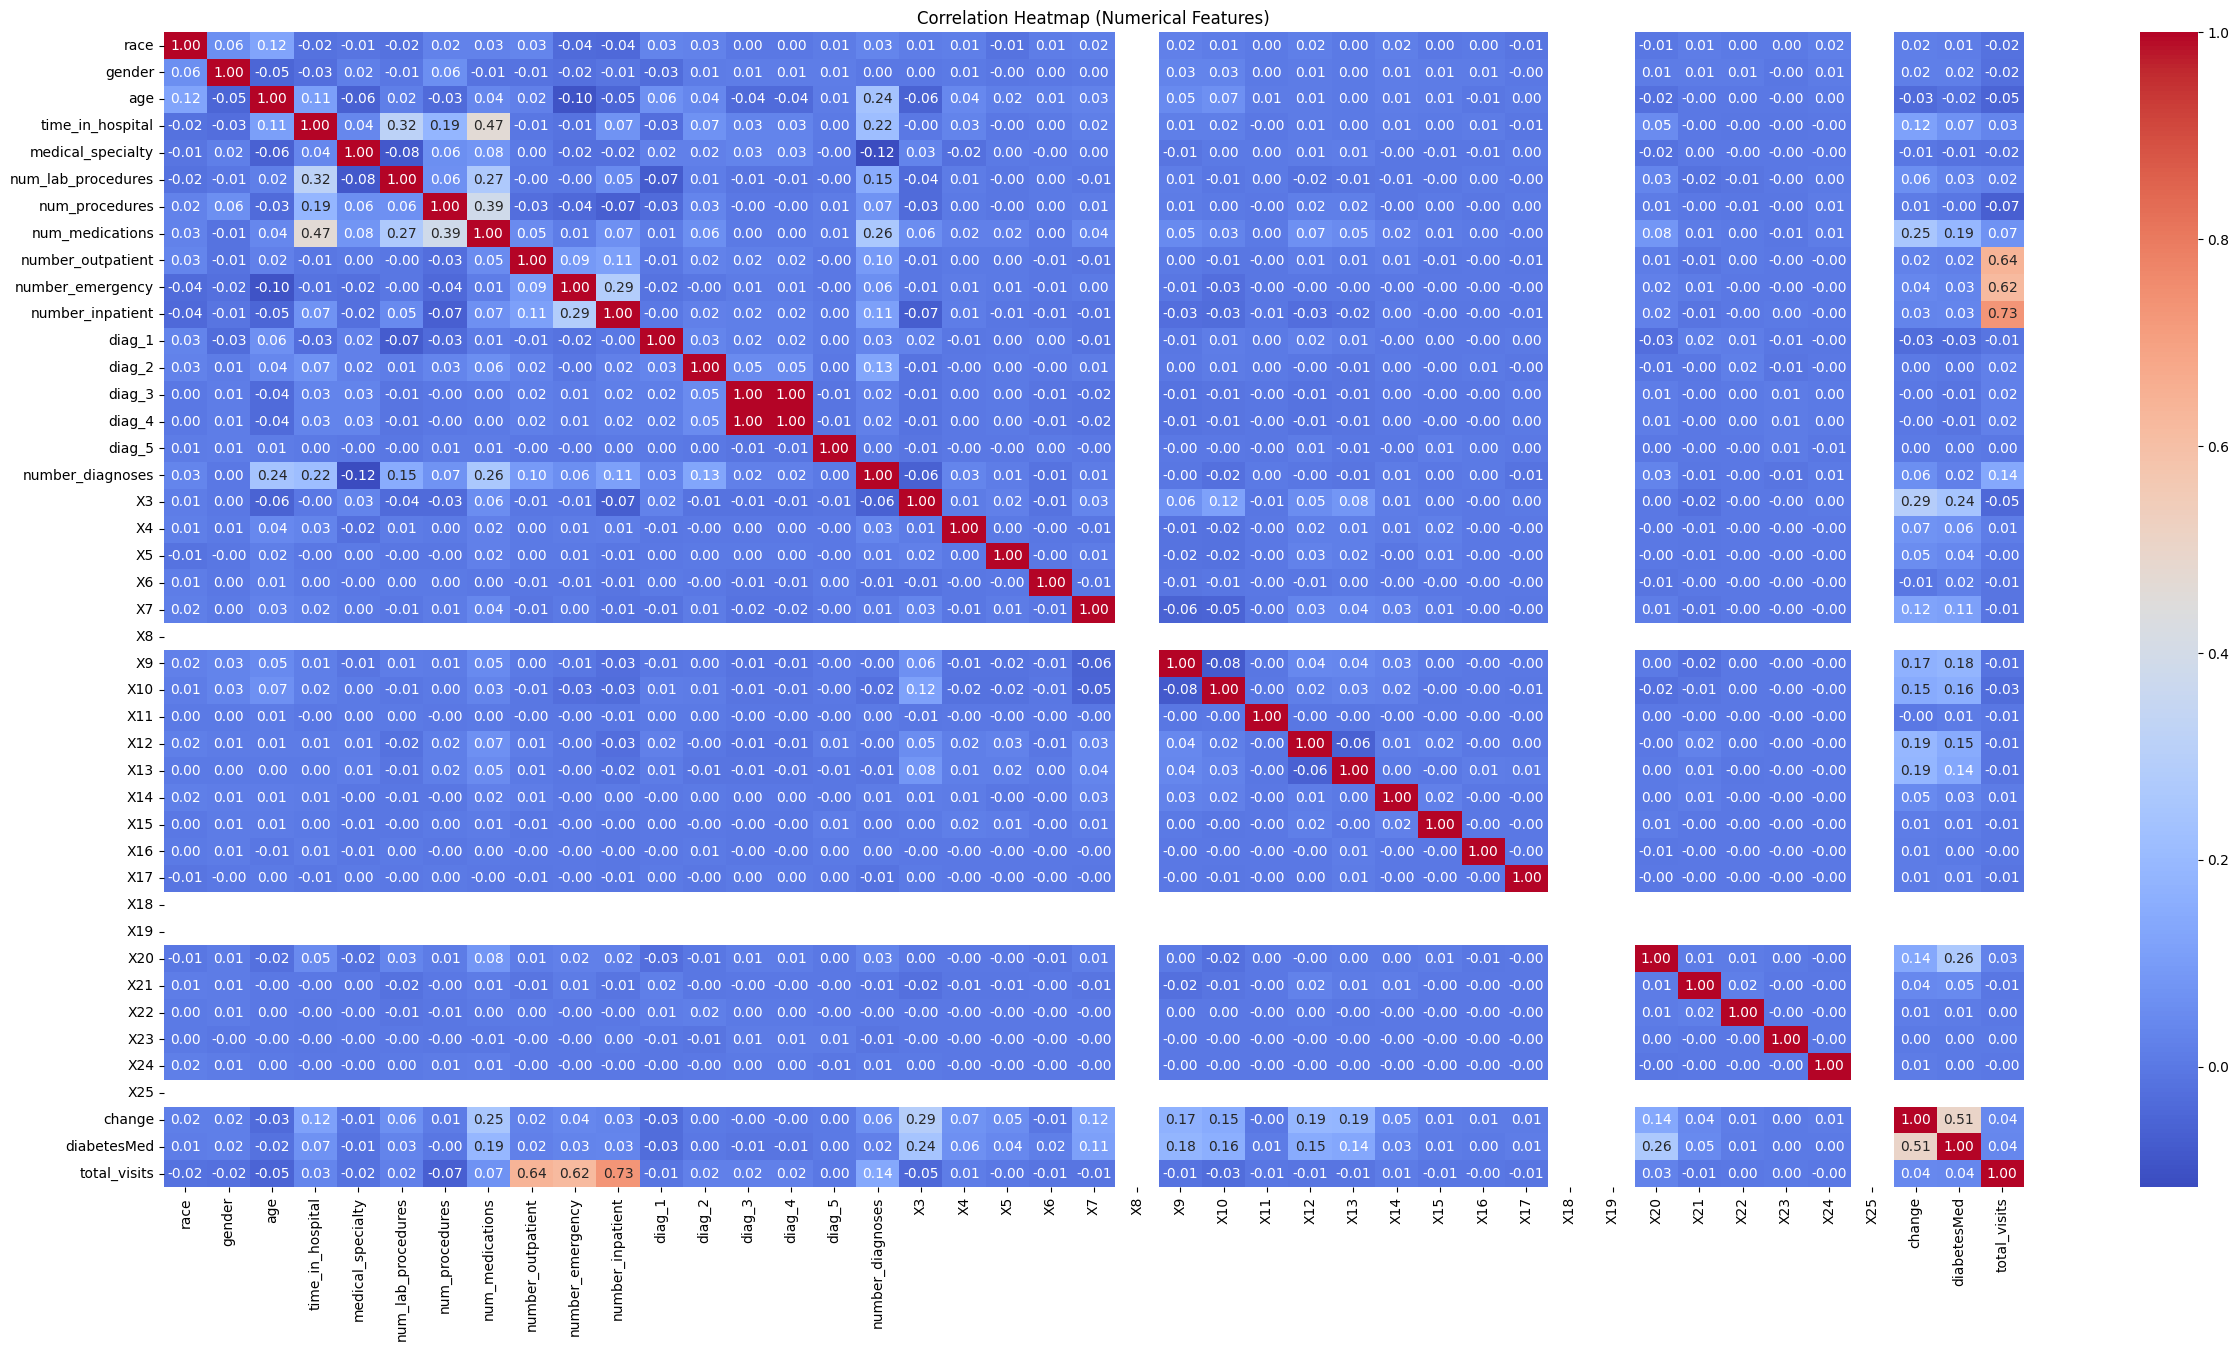

In [23]:
numeric_df = X_train_scaled.select_dtypes(include=[np.number])

plt.figure(figsize=(30, 15))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()